In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df=pd.read_csv('/content/deliveries.csv')

In [ ]:
df

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [ ]:
# Preprocess the data to aggregate runs per batsman per match
batsman_scores = df.groupby(['match_id', 'batter']).agg({'batsman_runs': 'sum'}).reset_index()
batsman_scores

,match_id,batter,batsman_runs
0,335982,AA Noffke,9
1,335982,B Akhil,0
2,335982,BB McCullum,158
3,335982,CL White,6
4,335982,DJ Hussey,12
...,...,...,...
16510,1426312,SP Narine,6
16511,1426312,SS Iyer,6
16512,1426312,Shahbaz Ahmed,8
16513,1426312,TM Head,0


In [ ]:
# Generate pseudo-dates for each match_id
unique_match_ids = batsman_scores['match_id'].unique()
match_id_to_date = {mid: pd.Timestamp("2023-01-01") + pd.Timedelta(days=i) for i, mid in enumerate(unique_match_ids)}

# Map pseudo-dates to the match_id column
batsman_scores['date'] = batsman_scores['match_id'].map(match_id_to_date)

# Group by batter and date after mapping pseudo-dates
batsman_scores = batsman_scores.groupby(['batter', 'date'])['batsman_runs'].sum().reset_index()
batsman_scores


,batter,date,batsman_runs
0,A Ashish Reddy,2023-10-14,10
1,A Ashish Reddy,2023-10-20,3
2,A Ashish Reddy,2023-10-27,8
3,A Ashish Reddy,2023-11-10,10
4,A Ashish Reddy,2023-11-13,4
...,...,...,...
16510,Z Khan,2024-06-02,4
16511,Z Khan,2024-07-17,2
16512,Z Khan,2024-08-04,1
16513,Z Khan,2024-09-12,2


In [ ]:
# Unique batters
batsmen = batsman_scores['batter'].unique()

In [ ]:
# Dictionary to store SARIMA results
batter_forecasts = {}

In [ ]:
# Loop through each batter and fit SARIMA
for batter in batsmen:
    # Filter data for the current batter
    batter_data = batsman_scores[batsman_scores['batter'] == batter]
    batter_data = batter_data.set_index('date')

    # Ensure consistent date frequency
    batter_ts = batter_data['batsman_runs'].resample('D').sum().fillna(0)
# Fit SARIMA model
    if len(batter_ts) > 20:  # Ensure enough data points
        # Example SARIMA parameters: (p, d, q) = (1, 1, 1), (P, D, Q, s) = (0, 1, 1, 7)
        model = SARIMAX(batter_ts, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
        results = model.fit(disp=False)

        # Forecast future runs
        forecast = results.get_forecast(steps=10).predicted_mean.sum()
        batter_forecasts[batter] = forecast

# Rank batters based on forecasted performance
top_batsmen = sorted(batter_forecasts.items(), key=lambda x: x[1], reverse=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa

In [ ]:
# Output the top batsmen
print("Top Batsmen Forecasted Performance:")
for rank, (batter, forecast) in enumerate(top_batsmen[:5], start=1):
    print(f"{rank}. {batter}: {forecast:.2f} runs")

Top Batsmen Forecasted Performance:
1. LJ Wright: 345.75 runs
2. A Mukund: 266.00 runs
3. IR Jaggi: 227.14 runs
4. P Dubey: 224.00 runs
5. Anirudh Singh: 219.37 runs


In [ ]:
# Step 6: Plotting the forecast for the top batsman
top_batter = top_batsmen[0][0]  # Get the top batsman
top_batter_data = batsman_scores[batsman_scores['batter'] == top_batter]
top_batter_data = top_batter_data.set_index('date')
top_batter_ts = top_batter_data['batsman_runs'].resample('D').sum().fillna(0)


In [ ]:
# Split into train and test sets
train_size = int(len(top_batter_ts) * 0.8)
train, test = top_batter_ts[:train_size], top_batter_ts[train_size:]

# Fit SARIMA model on the training data
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
results = model.fit(disp=False)

# Make predictions
predictions = results.forecast(steps=len(test))
predictions

,predicted_mean
2024-01-19,0.062571
2024-01-20,0.486604
2024-01-21,-1.017461
2024-01-22,-0.996028
2024-01-23,0.496843
2024-01-24,-1.412358
2024-01-25,-0.980051
2024-01-26,-1.318886
2024-01-27,-0.601011


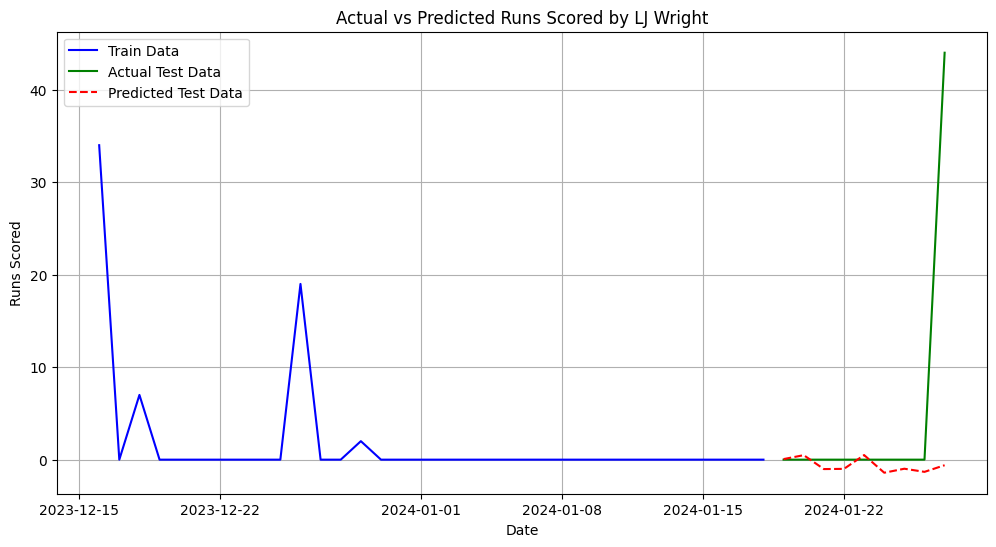

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train Data", color="blue")
plt.plot(test, label="Actual Test Data", color="green")
plt.plot(test.index, predictions, label="Predicted Test Data", color="red", linestyle="--")
plt.title(f"Actual vs Predicted Runs Scored by {top_batter}")
plt.xlabel("Date")
plt.ylabel("Runs Scored")
plt.legend()
plt.grid()
plt.show()